# This will test the successive prediction of the model

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
# Import MAPE from sklearn
from sklearn.metrics import mean_absolute_percentage_error as mape_sklearn

In [2]:
# Preprocessing of Data

# Loading of dataset (PSEI)
# We will only use the closing prices, hence we set usecols to index:4
data = np.genfromtxt('data/PSEI.csv', delimiter=',', skip_header=1, usecols=4)

# Splitting of dataset for training (80%) and testing (20%)
# Split data into training and testing
len_train = int(len(data) * 0.80)
data_test = data[len_train:]

# Creating a windowed datasets for testing (window size: 5)
windowed_data_test = []

test_data = np.zeros((len(data_test) - 5, 5))
for i in range(len(data_test) - 5):
    test_data[i] = data_test[i:i + 5]
    windowed_data_test.append(test_data[i])

In [3]:
def process_predictions(loaded_model, windowed_data, len_predictions):
    predicted_closings = []

    for i in range(len(windowed_data)):
        # Predict the closing price of the next len_predictions days
        for _ in range(len_predictions):
            # Predict the closing price of the next day
            prediction = loaded_model.predict(np.array([windowed_data[i]]))
            # Append the predicted closing price to the windowed data
            windowed_data[i] = np.append(windowed_data[i][1:], prediction)
            # Append the predicted closing price to the predicted_closings
            predicted_closings.append(prediction[0][0])


    return predicted_closings

In [4]:
# Loading of the model
loaded_model = tf.keras.models.load_model('exported_models/model_s5.keras')

In [5]:
mape_scores_dict = {f'{x}': 0 for x in range(1, 11)}

In [6]:
def windowed_data(data, window_size=5):
    windowed_data = []
    test_data = np.zeros((len(data) - window_size, window_size))
    for i in range(len(data) - window_size):
        test_data[i] = data[i:i + window_size]
        windowed_data.append(test_data[i])
    
    return windowed_data

In [7]:
def compare_results(actual_data, predicted_data, size_window):
    # flatten
    np.array(actual_data).flatten()
    np.array(predicted_data).flatten()

    predicted_data = predicted_data[:-5]

    # Reconstruct to windowed data
    actual_data = windowed_data(actual_data, window_size=size_window)
    predicted_data = windowed_data(predicted_data, window_size=size_window)

    # Calculate MAPE
    mape_scores = []

    for i in range(len(actual_data)):
        try:
            mape_scores.append(mape_sklearn(actual_data[i], predicted_data[i]))
        except:
            continue
    
    return mape_scores

In [8]:
%%capture
for i in range(1, 11):
    predicted_closings = process_predictions(loaded_model, windowed_data_test, i)
    mape_scores_dict[f'{i}'] = compare_results(np.array(data_test), np.array(predicted_closings), i)
    # Average
    mape_scores_dict[f'{i}'] = np.mean(mape_scores_dict[f'{i}'])

In [9]:
mape_scores_dict

{'1': 0.009727291371743631,
 '2': 0.13402770239927694,
 '3': 0.157821608187399,
 '4': 0.15645844385111812,
 '5': 0.13910008677355745,
 '6': 0.12494403400369929,
 '7': 0.11283264309986639,
 '8': 0.10013530109905247,
 '9': 0.08913624826137995,
 '10': 0.08975745414992246}

In [10]:
import matplotlib.pyplot as plt

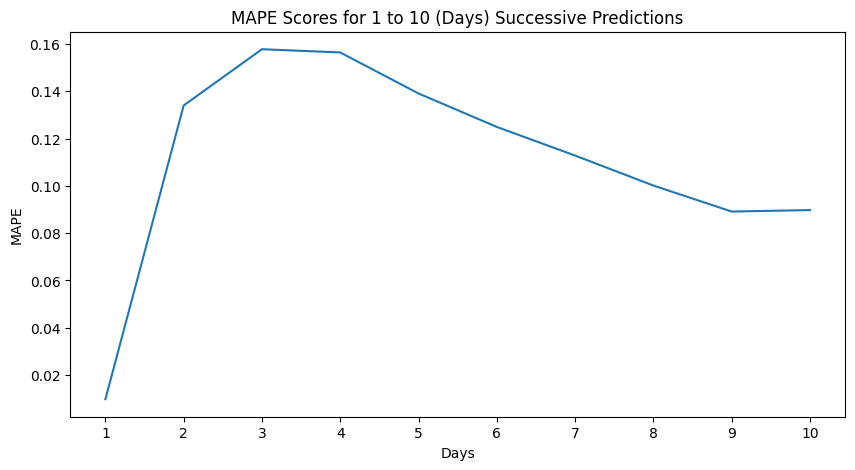

In [11]:
# Plotting of MAPE scores
plt.figure(figsize=(10, 5))
plt.plot(list(mape_scores_dict.keys()), list(mape_scores_dict.values()))
plt.xlabel('Days')
plt.ylabel('MAPE')
plt.title('MAPE Scores for 1 to 10 (Days) Successive Predictions')
plt.show()